**The Data Science Method**


1.   [Problem Identification](https://medium.com/@aiden.dataminer/the-data-science-method-problem-identification-6ffcda1e5152)

2.   [Data Wrangling](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-data-collection-organization-and-definitions-d19b6ff141c4)
  * Data Collection - Collected data from wikipedia and quandl wiki price dataset. The wikipedia showed us the currect S&P 500 companies and used their ticker symbols to query quandl wiki prices.
  * Data Organization - Done using cookiecutter
  * Data Definition
  * Data Cleaning - The S&P 500 data from quandls wiki price is clean and ready for analysis use but has lost its support from Quandl community as of April 11, 2018. So we will use this dataset to setup the protfolio optimizer with proof of concept then use a different data source later for cost efficiencies.

3.   [Exploratory Data Analysis](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-exploratory-data-analysis-bc84d4d8d3f9)
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   [Pre-processing and Training Data Development](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-pre-processing-and-training-data-development-fd2d75182967)
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
5.   [**Modeling**](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-modeling-56b4233cad1b)
  * Create dummy or indicator features for categorical variable
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

First, loads the needed packages and modules into Python. Then loads the data into a pandas dataframe for ease of use.

In [ ]:
#load python packages
import os
import random
import numpy as np
import pandas as pd
import pypfopt
import pickle

# from scipy.stats import norm

import datetime as dt
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [ ]:
random.seed(42)

In [ ]:
# prints current directory
current_dir = os.getcwd()
print("Current Directory: ")
print(current_dir)

In [ ]:
# prints parent directory
project_dir = os.path.abspath(os.path.join(os.path.join(current_dir, os.pardir), os.pardir))
print("Parent Directory: ")
print(project_dir)

In [5]:
print(os.listdir())

['3.0-jujbates-S&P500-PO_eda.ipynb', '.DS_Store', '5.0-jujbates-S&P500-PO_modeling.ipynb', '4.0-jujbates-S&P500-PO_pre-processing_and_training_data_development.ipynb', '.ipynb_checkpoints', '1.0-jujbates-S&P500-PO_problem_identification.ipynb', '2.0-jujbates-S&P500-PO_data_wrangling.ipynb']


In [6]:
plt.style.use('dark_background')
c = ['white', 'springgreen', 'fuchsia', 'lightcoral', 'red'] # Color
s = [24, 20, 16, 12]  # Size
w = [0.75, 1, 1.25, 1.50] # Line Width
ga = 0.10 # Grid Alpha

In [7]:
sp500_adj_close_df = pd.read_csv(project_dir + '/data/interim/'+ 'yahoo_sp500_adj_close_interim.csv', index_col=['date'])
sp500_index_adj_close_df = pd.read_csv(project_dir + '/data/interim/'+ 'yahoo_sp500_index_adj_close_interim.csv', index_col=['date'])

rand_one_year_window_sym_50_df = pd.read_csv(project_dir + '/data/interim/'+ 'sp500_rand_one_year_window_sym_50_interim.csv', index_col=['index'])
rand_one_year_window_sp500_index_df = pd.read_csv(project_dir + '/data/interim/'+ 'sp500_rand_one_year_window_sp500_index_interim.csv', index_col=['index'])

In [8]:
sp500_adj_close_df.index = pd.to_datetime(sp500_adj_close_df.index)
sp500_adj_close_df.index

DatetimeIndex(['1999-01-04', '1999-01-05', '1999-01-06', '1999-01-07',
               '1999-01-08', '1999-01-11', '1999-01-12', '1999-01-13',
               '1999-01-14', '1999-01-15',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='date', length=5283, freq=None)

In [9]:
sp500_index_adj_close_df.index = pd.to_datetime(sp500_adj_close_df.index)
sp500_index_adj_close_df.index

DatetimeIndex(['1999-01-04', '1999-01-05', '1999-01-06', '1999-01-07',
               '1999-01-08', '1999-01-11', '1999-01-12', '1999-01-13',
               '1999-01-14', '1999-01-15',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='date', length=5283, freq=None)

## Hypothesis formulation
#### Our Null hypothesis is just:

*Hnull:* the observed difference in the mean cumulative return of a portfolio generated with optimizated max sharpe ratio asset weights from 1 year of S&P 500 adjusted close and an equally weighted asset portolio from S&P 500 is due to chance (and thus not due to the optimizated max sharpe ratio asset weights from 1 year of S&P 500 adjusted close).


*Halternative:* the observed difference in the mean cumulative return of both portfolios is not due to chance (and is actually due to the optimizated max sharpe ratio asset weights from 1 year of S&P 500 adjusted close)

We're also going to pick a significance level of 0.05.

In [10]:
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import objective_functions
from pypfopt import expected_returns

def optimize_ef_max_sharpe_ratio(df):
    # Calculate expected returns and sample covariance
    mu = expected_returns.ema_historical_return(df)
    S = risk_models.semicovariance(df)

    # Optimise for maximal Sharpe ratio
    ef = EfficientFrontier(mu, S)
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    
    # Expected return, Volatility, and the Sharpe ratio
    er, vol, sr = ef.portfolio_performance()
    return cleaned_weights, er, vol, sr


    
def get_daily_portfolio_values(prices, allocs, sv):
    """ 
    Get the daily portfolio values.

    To get the daily values the function normalizes portfolio's adjusted closing prices, 
    allocates the normalized symbol by the portfolio allocations, scales to the the portfolio's 
    psition values with the start values and finally sums by each day.
  
    Parameters: 
    prices (dataFrame): Adjusted closing prices for symbols in portfolio  
    allocs (list): A list of 2 or more allocations to the stocks, must sum to 1.0
    sv (float): Start value of the portfolio
    

    Returns: 
    dataFrame: Portfolio values
  
    """
    normed_price = prices / prices.iloc[0]  # Normalize Adj Close Prices
    alloced_price = normed_price * allocs  # Allocated Normalize Adj Close Prices
    pos_val = alloced_price * sv  # Position Values
    return pos_val.sum(axis=1)  # Portfolio Values





In [11]:
def cumulative_return(df):
    return (df.iloc[-1] / df.iloc[0]) - 1

def daily_returns(df):
    return df.pct_change() * 100

def sharpe_ratio(adr, sddr, rfr=0):
    return (adr - rfr) / sddr 

In [12]:

def plot_portfolio_window_performance(pv_df, p_df):
        # Build plot figure
        fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 16))
        ax1.set_title(f"Portfolio Values", fontsize=s[1])
        ax1.set_xlabel(f"Date", fontsize=s[2])
        ax1.set_ylabel(f"Price", fontsize=s[2])
        
        # Plot the results
        pv_df.plot(kind='line', ax=ax1, legend=None)
        
        ax2.set_title(f"Cumulative Return Distribution", fontsize=s[1])
        ax2.set_xlabel(f"Cumulative Return (%)", fontsize=s[2])
        ax2.set_ylabel(f"Frequence", fontsize=s[2])
        
        # Plot the results
        sns.histplot(data=p_df, x='Cumulative Return', bins=30, ax=ax2)

        plt.show()

def portfolio_window_performance(prices, window_sym_df, projection_window_days=365, optimize=True, plot_flag=False):
    pv_df = pd.DataFrame(index=prices.index)
    dr_df = pd.DataFrame(index=prices.index)
    performance_df = pd.DataFrame(index=window_sym_df.columns)
    performance_df['Cumulative Return'] = 0
    for i in window_sym_df:
        sv = 1
        ii = i.split('-->')
        sd = dt.datetime.strptime(ii[0], '%Y-%m-%d %H:%M:%S') 
        ed = dt.datetime.strptime(ii[1], '%Y-%m-%d %H:%M:%S')   
        dd = dt.timedelta(days=projection_window_days)
        
        sym_list = window_sym_df[i].to_list()
        w_prices = prices.loc[sd:ed, sym_list].copy(deep=True)
        if optimize:
            cleaned_weights, er, vol, sr = optimize_ef_max_sharpe_ratio(w_prices)
            allocs = pd.DataFrame({'cleaned_weights': cleaned_weights}, index=w_prices.columns)['cleaned_weights'].to_list()
        else:
            allocs = 1  
        e_price = prices.loc[ed:ed+dd, sym_list]

        pv = get_daily_portfolio_values(e_price, allocs, sv=sv)
        pv_df.insert(0, i, pd.Series(pv, index=e_price.index))
        
        cr = cumulative_return(pv_df.loc[ed:ed+dd, i])            
        performance_df.loc[i, 'Cumulative Return'] = cr * 100

    pv = get_daily_portfolio_values(e_price, allocs, sv=sv)
    
    if plot_flag:
        plot_portfolio_window_performance(pv_df, performance_df)
        
       
    return performance_df


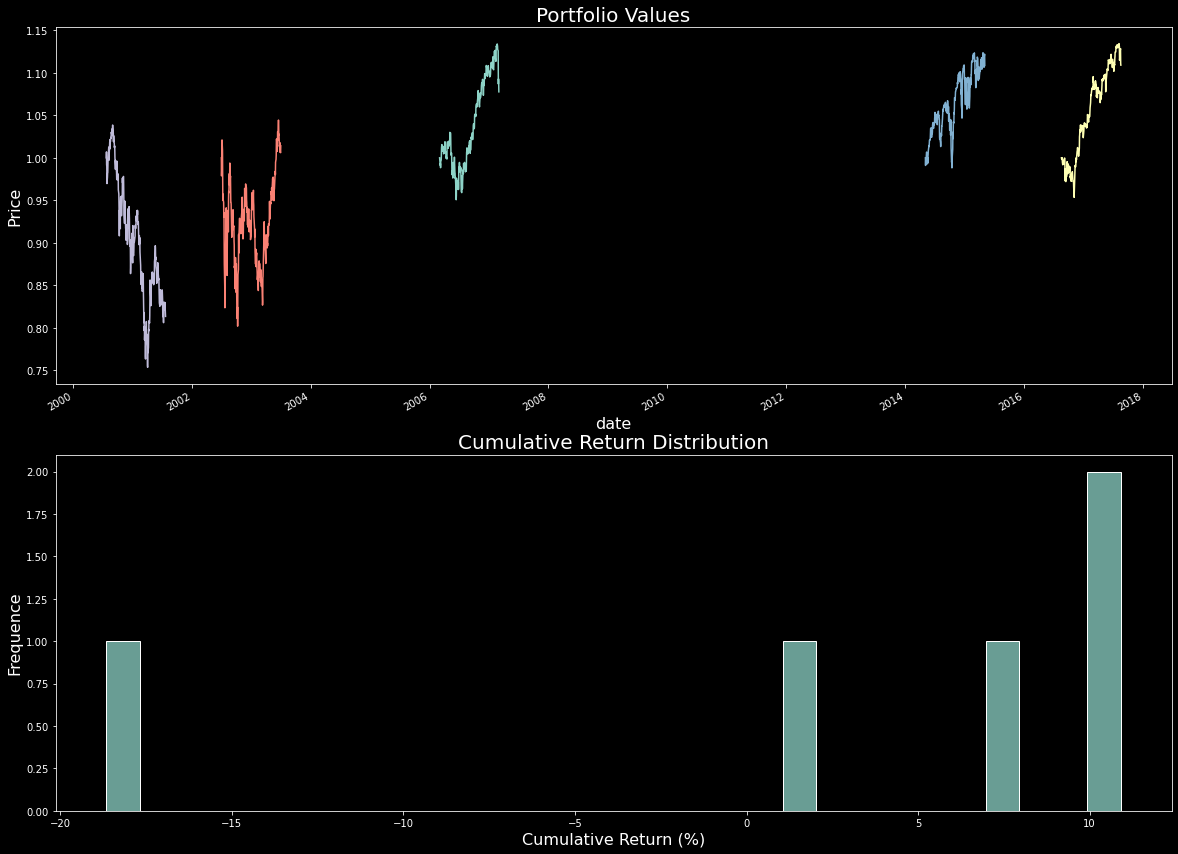

In [13]:
sp500_index_performance_df = portfolio_window_performance(sp500_index_adj_close_df, rand_one_year_window_sp500_index_df, projection_window_days=365, optimize=False, plot_flag=True)

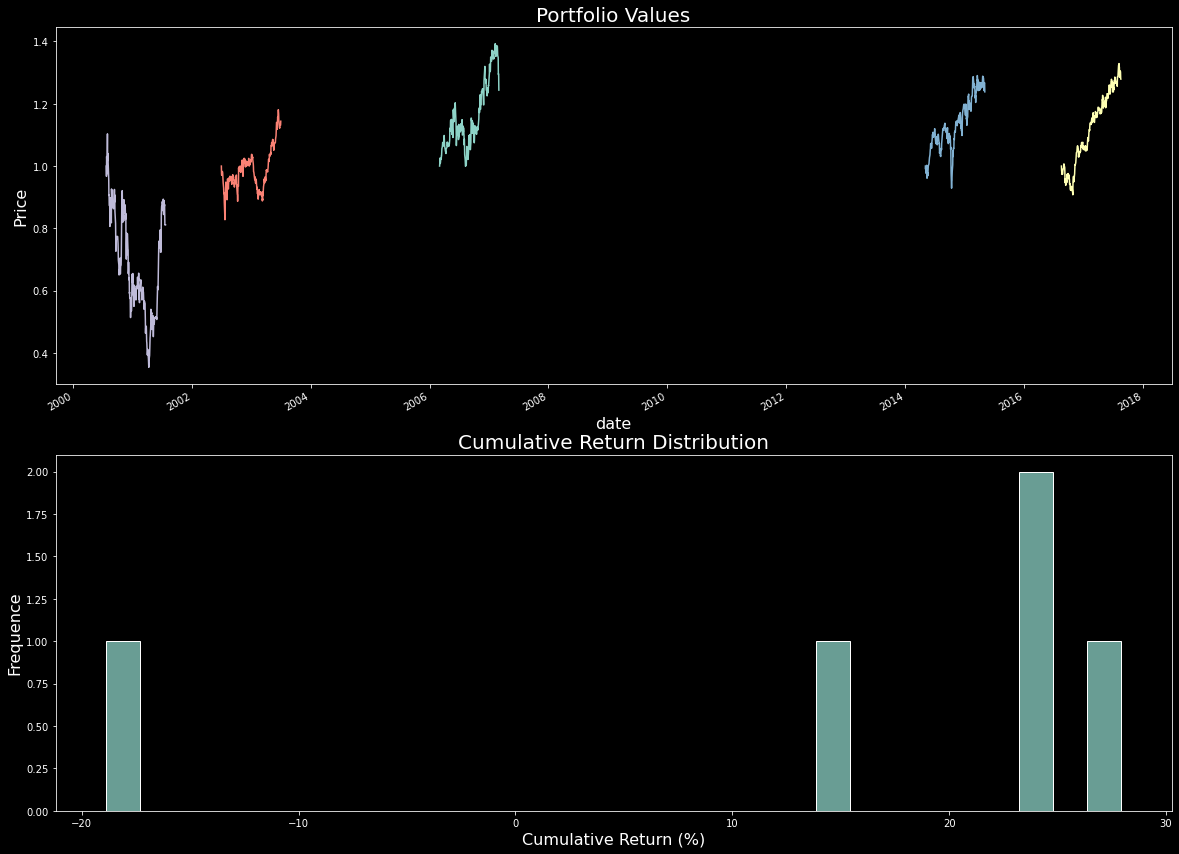

In [14]:
opt_port_performance_df = portfolio_window_performance(sp500_adj_close_df, rand_one_year_window_sym_50_df, projection_window_days=365, plot_flag=True)

In [15]:
import random

def get_random_date_ranges(start_date='1999-01-01', end_date='2019-12-31', range_window=365, evaluation_window=365, n_ranges=3):
    random_date_ranges = []

    range_window_dd = dt.timedelta(days=range_window)
    evaluation_window_dd = dt.timedelta(days=evaluation_window)

    start_date =  dt.datetime.strptime('1999-01-01', '%Y-%m-%d') 
    end_date =  dt.datetime.strptime('2019-12-31', '%Y-%m-%d') - (range_window_dd + evaluation_window_dd)    
    
    time_between_dates = end_date - start_date
    days_between_dates = time_between_dates.days    
    
    for i in range(n_ranges):
        random_number_of_days = random.randrange(days_between_dates)        
        random_start_date = start_date + dt.timedelta(days=random_number_of_days)
        
        random_end_date = random_start_date + range_window_dd
        random_date_ranges.append((random_start_date, random_end_date))
    return random_date_ranges


def get_gibbs_sample_points_date_ranges(sample_points, df, range_window=365):
    gibbs_sample_date_ranges = []
    range_window_dd = dt.timedelta(days=range_window)

    for pt in sample_points:
        start_date = df.iloc[pt,:].name.to_pydatetime()
        end_date = start_date + range_window_dd
        gibbs_sample_date_ranges.append((start_date, end_date))
        
    return gibbs_sample_date_ranges


def get_top_20_symbols_with_sharpe_ratio(date_ranges, df):
    sym_df = pd.DataFrame({})
    for sd, ed in date_ranges:
        prices = df.copy(deep=True).loc[sd : ed]
        dr = daily_returns(prices)
        sr = sharpe_ratio(dr.mean(), dr.std(), rfr=0)
        idx = str(sd) + '-->' + str(ed)
        if len(sr) == 1 and sr.index[0] == '^GSPC':
            sym_df[idx] = sr.index.tolist()
        else:
            sym_df[idx] = sr.sort_values(ascending=False)[:20].index.tolist()

    return sym_df

### Bootstrap Sampling

In [16]:
def run_bootstrap(prices, sp500_prices, n_iterations=100, p_size=0.50, checkpoint=False):
    # configure bootstrap
    n_size = int(len(prices) * p_size)

    # run bootstrap
    if checkpoint:
        pickle_off = open(project_dir + '/data/results/' + 'btsp_opt_port_stats.pkl','rb')
        btsp_opt_port_stats = pickle.load(pickle_off)

        pickle_off = open(project_dir + '/data/results/' + 'btsp_sp500_index_stats.pkl','rb')
        btsp_sp500_index_stats = pickle.load(pickle_off)
    else:
        btsp_opt_port_stats = list()
        btsp_sp500_index_stats = list()
    for i in tqdm(range(n_iterations)):

        dates = get_random_date_ranges(n_ranges=n_size)

        # get top 20 sharp ratio symbols for optimizer
        sym_20_df = get_top_20_symbols_with_sharpe_ratio(dates, prices)
        sp500_index_df = get_top_20_symbols_with_sharpe_ratio(dates, sp500_prices)
        
        # optimize and get preformance
        opt_port_performance_df = portfolio_window_performance(prices, sym_20_df, projection_window_days=365, optimize=True)
        sp500_index_performance_df = portfolio_window_performance(sp500_prices, sp500_index_df, projection_window_days=365, optimize=False)
        
        
        btsp_opt_port_stats.append(opt_port_performance_df['Cumulative Return'].mean())
        btsp_sp500_index_stats.append(sp500_index_performance_df['Cumulative Return'].mean())
        
        
        pickling_on = open(project_dir + '/data/results/' + 'btsp_opt_port_stats.pkl', 'wb')
        pickle.dump(btsp_opt_port_stats, pickling_on)
        pickling_on.close()

        pickling_on = open(project_dir + '/data/results/' + 'btsp_sp500_index_stats.pkl','wb')
        pickle.dump(btsp_sp500_index_stats, pickling_on)
        pickling_on.close()
        
        
    return btsp_opt_port_stats, btsp_sp500_index_stats

In [17]:
btsp_opt_port_stats, btsp_sp500_index_stats = run_bootstrap(sp500_adj_close_df, sp500_index_adj_close_df, n_iterations=300, p_size=0.75, checkpoint=False)


100%|██████████| 300/300 [9:13:56<00:00, 110.79s/it]  


In [18]:
btsp_opt_port_stats

[27.967777691671696,
 27.865858643438937,
 28.247425277120836,
 27.17837904204092,
 28.163939400979086,
 27.952351884439324,
 28.84586337250922,
 28.419255087957264,
 28.27323491623214,
 27.77745134425,
 27.253412291554906,
 26.98155281300549,
 27.460595008024406,
 26.69415233705814,
 27.389519925487765,
 27.982453537539335,
 28.124110748148386,
 26.95161762759064,
 27.454177500430106,
 27.613570296136917,
 27.698465062831563,
 28.172965619832144,
 27.901560333736246,
 28.460211691670747,
 27.333981913372032,
 28.233404930169545,
 27.470132610240224,
 28.266220716380104,
 27.60736676508298,
 27.48465847110649,
 27.249375532323597,
 27.217906608857238,
 27.958028223196198,
 28.528775335517967,
 28.856926110311893,
 27.43542086917718,
 27.927433096428704,
 27.84574116993627,
 27.734498522335855,
 27.485322424873726,
 28.297579946744094,
 27.801285215374055,
 28.4092863340166,
 27.925598425398956,
 27.75306764397852,
 28.46339664179827,
 28.422091344897183,
 27.425821808292618,
 27.870843

In [19]:
pickling_on = open(project_dir + '/data/results/' + 'btsp_opt_port_stats.pkl', 'wb')
pickle.dump(btsp_opt_port_stats, pickling_on)
pickling_on.close()

pickling_on = open(project_dir + '/data/results/' + 'btsp_sp500_index_stats.pkl','wb')
pickle.dump(btsp_sp500_index_stats, pickling_on)
pickling_on.close()


In [20]:
pickle_off = open(project_dir + '/data/results/' + 'btsp_opt_port_stats.pkl','rb')
btsp_opt_port_stats = pickle.load(pickle_off)

pickle_off = open(project_dir + '/data/results/' + 'btsp_sp500_index_stats.pkl','rb')
btsp_sp500_index_stats = pickle.load(pickle_off)


In [21]:
# confidence intervals
alpha = 0.95
btsp_stats = np.array(btsp_opt_port_stats) - np.array(btsp_sp500_index_stats)

p = round(((1.0 - alpha)/2.0) * 100, 4)

btsp_opt_port_lower = np.percentile(btsp_opt_port_stats, p)
btsp_sp500_index_lower = np.percentile(btsp_sp500_index_stats, p)
btsp_stats_lower = np.percentile(btsp_stats, p)

print('p:', p)
print('btsp_opt_port_lower:', btsp_opt_port_lower)
print('btsp_sp500_index_lower:', btsp_sp500_index_lower)
print('btsp_stats_lower:', btsp_stats_lower)


p = round((alpha+((1.0-alpha)/2.0)) * 100, 4)

btsp_opt_port_upper = np.percentile(btsp_opt_port_stats, p)
btsp_sp500_index_upper = np.percentile(btsp_sp500_index_stats, p)
btsp_stats_upper = np.percentile(btsp_stats, p)

print()
print('p:', p)
print('btsp_opt_port_upper:', btsp_opt_port_upper)
print('btsp_sp500_index_upper:', btsp_sp500_index_upper)
print('btsp_stats_upper:', btsp_stats_upper)


print()
print('btsp_opt_port %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, btsp_opt_port_lower, btsp_opt_port_upper))
print('btsp_sp500_index %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, btsp_sp500_index_lower, btsp_sp500_index_upper))
print('btsp_difference %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, btsp_stats_lower, btsp_stats_upper))



p: 2.5
btsp_opt_port_lower: 26.68095442554302
btsp_sp500_index_lower: 4.810601767878952
btsp_stats_lower: 21.559359736931018

p: 97.5
btsp_opt_port_upper: 28.748222708086786
btsp_sp500_index_upper: 5.715587429278887
btsp_stats_upper: 23.406066578751055

btsp_opt_port 95.0 confidence interval 26.7% and 28.7%
btsp_sp500_index 95.0 confidence interval 4.8% and 5.7%
btsp_difference 95.0 confidence interval 21.6% and 23.4%


In [22]:
print(np.array(btsp_opt_port_stats).shape)
print(np.array(btsp_sp500_index_stats).shape)

(300,)
(300,)


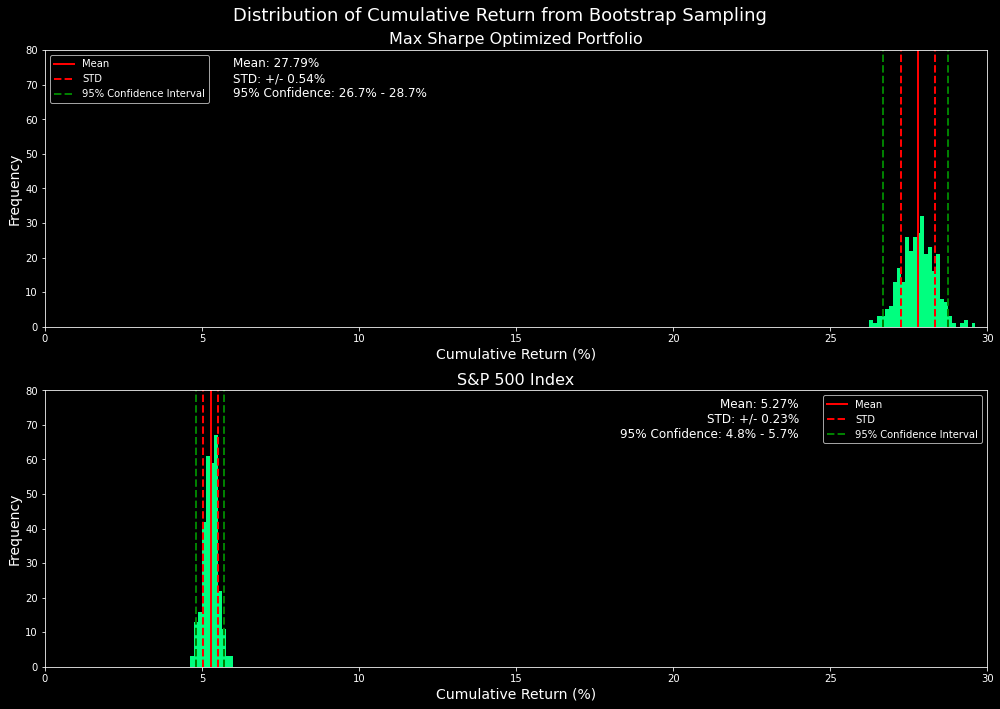

In [151]:
left, width = .20 , .6
bottom, height = .25, .725
right = left + width
top = bottom + height


btsp_opt_port_stats_mean = np.mean(btsp_opt_port_stats)
btsp_opt_port_stats_std = np.std(btsp_opt_port_stats)

btsp_sp500_index_stats_mean = np.mean(btsp_sp500_index_stats)
btsp_sp500_index_stats_std = np.std(btsp_sp500_index_stats)


fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))
fig.suptitle('Distribution of Cumulative Return from Bootstrap Sampling', fontsize=18)

sns.distplot(np.array(btsp_opt_port_stats), kde=False, bins=40, ax=ax1,
             hist_kws={"alpha": 1, "color": c[1], "range": (25, 30), })


ax1.axvline(btsp_opt_port_stats_mean, color='red', linestyle='solid', linewidth=2, label='Mean')
ax1.axvline(btsp_opt_port_stats_mean + btsp_opt_port_stats_std, color='red', linestyle='dashed', linewidth=2, label='STD')
ax1.axvline(btsp_opt_port_stats_mean - btsp_opt_port_stats_std, color='red', linestyle='dashed', linewidth=2)

# To plot the std lines we plot both the positive and negative values 
ax1.axvline(btsp_opt_port_lower, color='g', linestyle='dashed', linewidth=2, label='95% Confidence Interval')
ax1.axvline(btsp_opt_port_upper, color='g', linestyle='dashed', linewidth=2)

text1 = "Mean: {}%\nSTD: +/- {}%\n95% Confidence: {}% - {}%".format(round(btsp_opt_port_stats_mean, 2), round(btsp_opt_port_stats_std, 2),  round(btsp_opt_port_lower, 1), round(btsp_opt_port_upper, 1))
ax1.text(left, top, text1,
    fontsize='large',
    horizontalalignment='left',
    verticalalignment='top',
    transform=ax1.transAxes)


ax1.set_xlim(0, 30)
ax1.set_ylim(0, 80)
ax1.set_title('Max Sharpe Optimized Portfolio', fontsize=16)
ax1.set_xlabel('Cumulative Return (%)', fontsize=14)
ax1.set_ylabel('Frequency', fontsize=14)
ax1.legend(loc="upper left")


sns.distplot(np.array(btsp_sp500_index_stats), kde=False, bins=40, ax=ax2,
             hist_kws={"alpha": 1, "color": c[1], "range": (2.5, 7.5)})

ax2.axvline(btsp_sp500_index_stats_mean, color='red', linestyle='solid', linewidth=2, label='Mean')
ax2.axvline(btsp_sp500_index_stats_mean + btsp_sp500_index_stats_std, color='red', linestyle='dashed', linewidth=2, label='STD')
ax2.axvline(btsp_sp500_index_stats_mean - btsp_sp500_index_stats_std, color='red', linestyle='dashed', linewidth=2)

# To plot the std lines we plot both the positive and negative values 
ax2.axvline(btsp_sp500_index_lower, color='g', linestyle='dashed', linewidth=2, label='95% Confidence Interval')
ax2.axvline(btsp_sp500_index_upper, color='g', linestyle='dashed', linewidth=2)

text2 = "Mean: {}%\nSTD: +/- {}%\n95% Confidence: {}% - {}%".format(round(btsp_sp500_index_stats_mean, 2), round(btsp_sp500_index_stats_std, 2),  round(btsp_sp500_index_lower, 1), round(btsp_sp500_index_upper, 1))
ax2.text(right, top, text2,
    fontsize='large',
    horizontalalignment='right',
    verticalalignment='top',
    transform=ax2.transAxes)

            
ax2.set_xlim(0, 30)
ax2.set_ylim(0, 80)
ax2.set_title('S&P 500 Index', fontsize=16)
ax2.set_xlabel('Cumulative Return (%)', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=14)
ax2.legend(loc="upper right")


fig.tight_layout() 

plt.savefig(project_dir + '/reports/figures/' + 'histo_cumuliative_return_bootstrap_sampling.png')



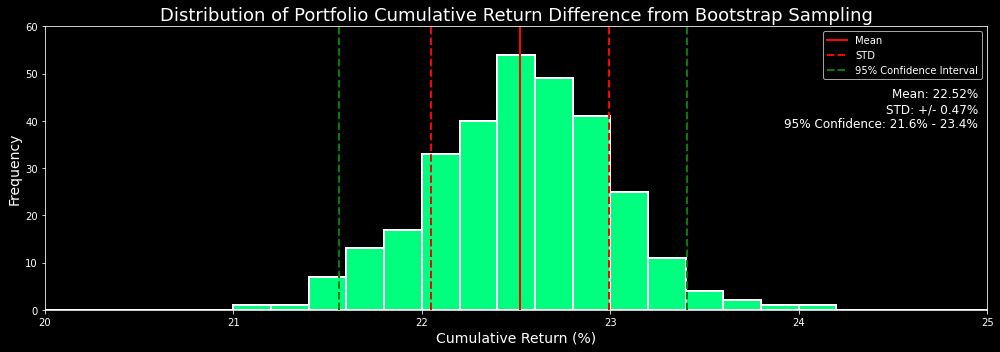

In [152]:
left, width = .20 , .79
bottom, height = .25, .535
right = left + width
top = bottom + height


btsp_stats_mean = btsp_stats.mean()
btsp_stats_std = btsp_stats.std()

fig, ax = plt.subplots(1, figsize=(14, 5))

sns.distplot(btsp_stats, kde=False, bins=50, ax=ax,
             hist_kws={"linewidth": 2, "alpha": 1, "color": c[1], "range": (15, 25), "edgecolor": c[0]})

ax.axvline(btsp_stats_mean, color='red', linestyle='solid', linewidth=2, label='Mean')
ax.axvline(btsp_stats_mean + btsp_stats_std, color='red', linestyle='dashed', linewidth=2, label='STD')
ax.axvline(btsp_stats_mean - btsp_stats_std, color='red', linestyle='dashed', linewidth=2)

# To plot the std lines we plot both the positive and negative values 
ax.axvline(btsp_stats_lower, color='g', linestyle='dashed', linewidth=2, label='95% Confidence Interval')
ax.axvline(btsp_stats_upper, color='g', linestyle='dashed', linewidth=2)

text = "Mean: {}%\nSTD: +/- {}%\n95% Confidence: {}% - {}%".format(round(btsp_stats_mean, 2), round(btsp_stats_std, 2),  round(btsp_stats_lower, 1), round(btsp_stats_upper, 1))
ax.text(right, top, text,
    fontsize='large',
    horizontalalignment='right',
    verticalalignment='top',
    transform=ax.transAxes)

ax.set_xlim(20, 25)
ax.set_ylim(0, 60)
ax.set_title('Distribution of Portfolio Cumulative Return Difference from Bootstrap Sampling', fontsize=18)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_xlabel('Cumulative Return (%)', fontsize=14)
ax.legend(loc="upper right")



fig.tight_layout() 

plt.savefig(project_dir + '/reports/figures/' + 'histo_cumuliative_return_difference_bootstrap_sampling.png')


### Gibbs Sampling

In [85]:
def gibbs_conditional_sampler(df, conditional_distance=252):
    rand_upper_bound = df.shape[0] - conditional_distance
    attempts = 0
    sample_points = []
    sample_points.append(random.randint(0, rand_upper_bound))

    while attempts < 1000000:
        rand_point = random.randint(0, rand_upper_bound)
        upper_bound = rand_point + conditional_distance
        lower_bound = rand_point - conditional_distance
        flag_sample_pts = np.zeros(len(sample_points))
        for i, pt in enumerate(sample_points):
            if pt < lower_bound or pt > upper_bound:
                flag_sample_pts[i] = 1
            else:
                attempts = attempts + 1
                break
                
        if sum(flag_sample_pts) == len(flag_sample_pts):
            sample_points.append(rand_point)
            attempts = 0
    return sample_points


def run_gibbs_sample(prices, sp500_prices, conditional_distance=252):
    num_samples = int((prices.shape[0] - conditional_distance) / conditional_distance) - 1
    sample_points = []
    while len(sample_points) < num_samples:
        sample_points = gibbs_conditional_sampler(prices)
        print(len(sample_points), sample_points)
        
    dates = get_gibbs_sample_points_date_ranges(sample_points, prices)
    
    # get top 20 sharp ratio symbols for optimizer
    sym_20_df = get_top_20_symbols_with_sharpe_ratio(dates, prices)
    sp500_index_df = get_top_20_symbols_with_sharpe_ratio(dates, sp500_prices)

    # optimize and get preformance
    opt_port_performance_df = portfolio_window_performance(prices, sym_20_df, projection_window_days=365, optimize=True)
    sp500_index_performance_df = portfolio_window_performance(sp500_prices, sp500_index_df, projection_window_days=365, optimize=False)

    return opt_port_performance_df, sp500_index_performance_df
        




In [86]:
gbsp_opt_port_stats, gbsp_sp500_index_stats = run_gibbs_sample(sp500_adj_close_df, sp500_index_adj_close_df)

16 [260, 4102, 1277, 2402, 4615, 2951, 3360, 988, 717, 3639, 1581, 1923, 2670, 4878, 2, 4361]
15 [4051, 2491, 4491, 335, 2818, 4908, 2025, 1582, 3528, 60, 3202, 1179, 898, 630, 3796]
16 [1239, 4774, 1765, 2336, 944, 4465, 2975, 3630, 126, 4048, 3252, 568, 2643, 2074, 1499, 5027]
16 [155, 3067, 1471, 1021, 411, 4109, 1728, 3635, 4695, 2416, 5003, 1997, 2691, 3366, 4410, 696]
15 [1513, 2942, 4367, 1067, 3676, 464, 4695, 2076, 754, 1786, 5025, 3989, 24, 2489, 3302]
15 [2522, 1068, 804, 3792, 5019, 64, 3327, 2885, 2014, 4573, 4151, 1723, 1349, 2267, 404]
16 [3898, 4597, 2517, 261, 3269, 1079, 2062, 4209, 1697, 4957, 543, 1422, 3524, 2835, 822, 5]
15 [4257, 905, 2671, 1290, 3887, 1875, 4908, 507, 3277, 29, 3600, 2323, 1551, 4541, 3010]
15 [1271, 782, 3873, 92, 3496, 430, 2824, 1996, 4896, 4598, 3139, 1556, 2535, 4309, 2272]
14 [4856, 66, 4438, 3520, 2210, 3913, 1253, 1624, 2687, 3080, 1909, 981, 570, 4174]
17 [297, 1441, 2248, 4083, 843, 4398, 2843, 1791, 1105, 4997, 4682, 3570, 3152, 574, 

In [87]:
pickling_on = open(project_dir + '/data/results/' + 'gbsp_opt_port_stats.pkl', 'wb')
pickle.dump(gbsp_opt_port_stats, pickling_on)
pickling_on.close()

pickling_on = open(project_dir + '/data/results/' + 'gbsp_sp500_index_stats.pkl','wb')
pickle.dump(gbsp_sp500_index_stats, pickling_on)
pickling_on.close()


In [146]:
pickle_off = open(project_dir + '/data/results/' + 'gbsp_opt_port_stats.pkl','rb')
gbsp_opt_port_stats = pickle.load(pickle_off)

pickle_off = open(project_dir + '/data/results/' + 'gbsp_sp500_index_stats.pkl','rb')
gbsp_sp500_index_stats = pickle.load(pickle_off)


In [147]:
# confidence intervals
alpha = 0.95

gbsp_stats = np.array(gbsp_opt_port_stats) - np.array(gbsp_sp500_index_stats)

p = round(((1.0 - alpha)/2.0) * 100, 4)

gbsp_opt_port_lower = np.percentile(gbsp_opt_port_stats, p)
gbsp_sp500_index_lower = np.percentile(gbsp_sp500_index_stats, p)
gbsp_stats_lower = np.percentile(gbsp_stats, p)

print('p:', p)
print('gbsp_opt_port_lower:', gbsp_opt_port_lower)
print('gbsp_sp500_index_lower:', gbsp_sp500_index_lower)
print('gbsp_stats_lower:', gbsp_stats_lower)


p = round((alpha+((1.0-alpha)/2.0)) * 100, 4)

gbsp_opt_port_upper = np.percentile(gbsp_opt_port_stats, p)
gbsp_sp500_index_upper = np.percentile(gbsp_sp500_index_stats, p)
gbsp_stats_upper = np.percentile(gbsp_stats, p)

print()
print('p:', p)
print('gbsp_opt_port_upper:', gbsp_opt_port_upper)
print('gbsp_sp500_index_upper:', gbsp_sp500_index_upper)
print('gbsp_stats_upper:', gbsp_stats_upper)


print()
print('gbsp_opt_port %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, gbsp_opt_port_lower, gbsp_opt_port_upper))
print('gbsp_sp500_index %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, gbsp_sp500_index_lower, gbsp_sp500_index_upper))
print('gbsp_difference %.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, gbsp_stats_lower, gbsp_stats_upper))

p: 2.5
gbsp_opt_port_lower: -20.785311415749916
gbsp_sp500_index_lower: -17.08086068170579
gbsp_stats_lower: -21.596547797618598

p: 97.5
gbsp_opt_port_upper: 79.30654779114684
gbsp_sp500_index_upper: 38.92384506566552
gbsp_stats_upper: 81.13328239740527

gbsp_opt_port 95.0 confidence interval -20.8% and 79.3%
gbsp_sp500_index 95.0 confidence interval -17.1% and 38.9%
gbsp_difference 95.0 confidence interval -21.6% and 81.1%


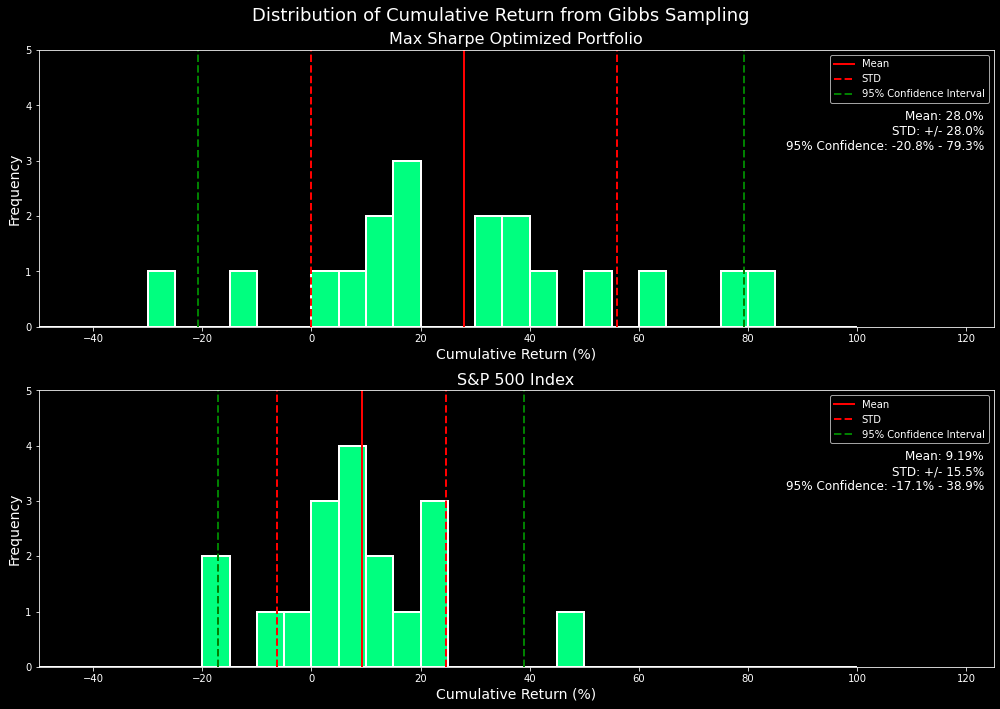

In [153]:
left, width = .20 , .79
bottom, height = .25, .535
right = left + width
top = bottom + height


gbsp_opt_port_stats_mean = np.mean(gbsp_opt_port_stats)[0]
gbsp_opt_port_stats_std = np.std(gbsp_opt_port_stats)[0]

gbsp_sp500_index_stats_mean = np.mean(gbsp_sp500_index_stats)[0]
gbsp_sp500_index_stats_std = np.std(gbsp_sp500_index_stats)[0]



fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))
fig.suptitle('Distribution of Cumulative Return from Gibbs Sampling', fontsize=18)


sns.distplot(gbsp_opt_port_stats,  kde=False, bins=30, ax=ax1,
             hist_kws={"linewidth": 2, "alpha": 1, "color": c[1], "range": (-50, 100), "edgecolor": c[0]})

ax1.axvline(gbsp_opt_port_stats_mean, color='red', linestyle='solid', linewidth=2, label='Mean')
ax1.axvline(gbsp_opt_port_stats_mean + gbsp_opt_port_stats_std, color='red', linestyle='dashed', linewidth=2, label='STD')
ax1.axvline(gbsp_opt_port_stats_mean - gbsp_opt_port_stats_std, color='red', linestyle='dashed', linewidth=2)

# To plot the std lines we plot both the positive and negative values 
ax1.axvline(gbsp_opt_port_lower, color='g', linestyle='dashed', linewidth=2, label='95% Confidence Interval')
ax1.axvline(gbsp_opt_port_upper, color='g', linestyle='dashed', linewidth=2)

text1 = "Mean: {}%\nSTD: +/- {}%\n95% Confidence: {}% - {}%".format(round(gbsp_opt_port_stats_mean, 2), round(gbsp_opt_port_stats_std, 2),  round(gbsp_opt_port_lower, 1), round(gbsp_opt_port_upper, 1))
ax1.text(right, top, text1,
    fontsize='large',
    horizontalalignment='right',
    verticalalignment='top',
    transform=ax1.transAxes)

ax1.set_xlim(-50, 125)
ax1.set_ylim(0, 5)
ax1.set_title('Max Sharpe Optimized Portfolio', fontsize=16)
ax1.set_ylabel('Frequency', fontsize=14)
ax1.set_xlabel('Cumulative Return (%)', fontsize=14)
ax1.legend(loc="upper right")



sns.distplot(gbsp_sp500_index_stats, kde=False, bins=30, ax=ax2, 
             hist_kws={"linewidth": 2, "alpha": 1, "color": c[1], "range": (-50, 100), "edgecolor": c[0]})

ax2.axvline(gbsp_sp500_index_stats_mean, color='red', linestyle='solid', linewidth=2, label='Mean')
ax2.axvline(gbsp_sp500_index_stats_mean + gbsp_sp500_index_stats_std, color='red', linestyle='dashed', linewidth=2, label='STD')
ax2.axvline(gbsp_sp500_index_stats_mean - gbsp_sp500_index_stats_std, color='red', linestyle='dashed', linewidth=2)

# To plot the std lines we plot both the positive and negative values 
ax2.axvline(gbsp_sp500_index_lower, color='g', linestyle='dashed', linewidth=2, label='95% Confidence Interval')
ax2.axvline(gbsp_sp500_index_upper, color='g', linestyle='dashed', linewidth=2)

text2 = "Mean: {}%\nSTD: +/- {}%\n95% Confidence: {}% - {}%".format(round(gbsp_sp500_index_stats_mean, 2), round(gbsp_sp500_index_stats_std, 2),  round(gbsp_sp500_index_lower, 1), round(gbsp_sp500_index_upper, 1))
ax2.text(right, top, text2,
    fontsize='large',
    horizontalalignment='right',
    verticalalignment='top',
    transform=ax2.transAxes)

ax2.set_xlim(-50, 125)
ax2.set_ylim(0, 5)
ax2.set_title('S&P 500 Index', fontsize=16)
ax2.set_ylabel('Frequency', fontsize=14)
ax2.set_xlabel('Cumulative Return (%)', fontsize=14)

ax2.legend(loc="upper right")


fig.tight_layout() 

plt.savefig(project_dir + '/reports/figures/' + 'histo_cumuliative_return_gibbs_sampling.png')


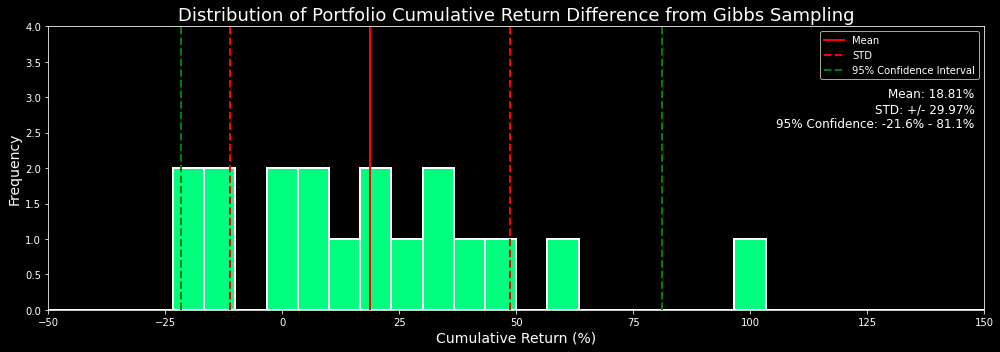

In [154]:
left, width = .20 , .79
bottom, height = .25, .535
right = left + width
top = bottom + height


gbsp_stats_mean = np.mean(gbsp_stats)
gbsp_stats_std = np.std(gbsp_stats)


fig, ax = plt.subplots(1, figsize=(14, 5))

sns.distplot(gbsp_stats, kde=False, bins=30, ax=ax,
             hist_kws={"linewidth": 2, "alpha": 1, "color": c[1], "range": (-50, 150), "edgecolor": c[0]})

ax.axvline(gbsp_stats_mean, color='red', linestyle='solid', linewidth=2, label='Mean')
ax.axvline(gbsp_stats_mean + gbsp_stats_std, color='red', linestyle='dashed', linewidth=2, label='STD')
ax.axvline(gbsp_stats_mean - gbsp_stats_std, color='red', linestyle='dashed', linewidth=2)

# To plot the std lines we plot both the positive and negative values 
ax.axvline(gbsp_stats_lower, color='g', linestyle='dashed', linewidth=2, label='95% Confidence Interval')
ax.axvline(gbsp_stats_upper, color='g', linestyle='dashed', linewidth=2)


text = "Mean: {}%\nSTD: +/- {}%\n95% Confidence: {}% - {}%".format(round(gbsp_stats_mean, 2), round(gbsp_stats_std, 2),  round(gbsp_stats_lower, 1), round(gbsp_stats_upper, 1))
ax.text(right, top, text,
    fontsize='large',
    horizontalalignment='right',
    verticalalignment='top',
    transform=ax.transAxes)

ax.set_xlim(-50, 150)
ax.set_ylim(0, 4)
ax.set_title('Distribution of Portfolio Cumulative Return Difference from Gibbs Sampling', fontsize=18)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_xlabel('Cumulative Return (%)', fontsize=14)
ax.legend(loc="upper right")


fig.tight_layout() 

plt.savefig(project_dir + '/reports/figures/' + 'histo_cumuliative_return_difference_gibbs_sampling.png')

